In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
from Utils.plotting_utils import multipage
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from Utils.DebuggingUtils import print_memory_stats

In [7]:
dim = 6
epochs = 10
n_flow_steps = 2
n_distributions = 4

In [8]:
flow_type="ReverseIAF"
batch_size=int(1e3)
seed=0
n_samples_expectation=int(1e5)
save=True 
n_plots=5
train_AIS_params=False
step_size=1.0
learnt_dist_kwargs={"lr": 1e-4}

In [9]:
def plotter(*args, **kwargs):
    plot_samples_vs_contours_many_well(*args, **kwargs)

In [11]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type=flow_type,
                           n_flow_steps=n_flow_steps)
tester = AIS_trainer(target, learnt_sampler, loss_type=False, n_distributions=n_distributions
                         , n_steps_transition_operator=1,
                         step_size=step_size, transition_operator="HMC", learnt_dist_kwargs=learnt_dist_kwargs,
                         loss_type_2="alpha_2", train_AIS_params=train_AIS_params, inner_loop_steps=5)

setting device as cpu


# New Plotter

In [22]:
import itertools
def plot_marginals_many_well(learnt_dist_manager, n_samples=1000, bounds=([-3, 3], [-3, 3]),
                                       n_points_contour=100, title=None, samples_q=None,
                                       log_prob_contour=True, clamp_samples=10, alpha=0.2):
    if samples_q is None:
        samples_q = learnt_dist_manager.learnt_sampling_dist.sample((n_samples,))
    samples_q = torch.clamp(samples_q, -clamp_samples, clamp_samples).cpu().detach().numpy()
    fig, axs = plt.subplots(learnt_dist_manager.target_dist.dim, learnt_dist_manager.target_dist.dim, figsize=(7, 3 * n_plots), sharex="row", sharey="row")
    for i in range(learnt_dist_manager.target_dist.dim):
        for j in range(learnt_dist_manager.target_dist.dim):
            if i != j:
                axs[i, j].plot(samples_q[:, i], samples_q[:, j], "o", alpha=alpha)
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()

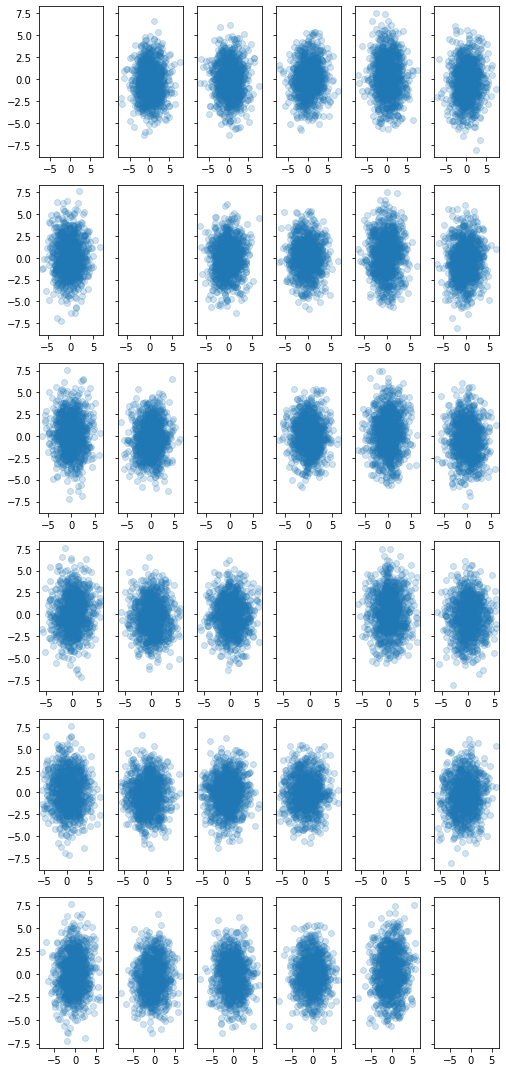

In [23]:
plot_marginals_many_well(tester)

# Current Plotter

In [15]:
import itertools
def plot_samples_vs_contours_many_well(learnt_dist_manager, n_samples=1000, bounds=([-3, 3], [-3, 3]),
                                       n_points_contour=100, title=None, samples_q=None,
                                       log_prob_contour=True, clamp_samples=10, alpha=0.2):
    # when we can't sample from target distribution
    if samples_q is None:
        samples_q = learnt_dist_manager.learnt_sampling_dist.sample((n_samples,))
    samples_q = torch.clamp(samples_q, -clamp_samples, clamp_samples).cpu().detach().numpy()
    x_points_dim1 = torch.linspace(bounds[0][0], bounds[0][1], n_points_contour)
    x_points_dim2 = torch.linspace(bounds[1][0], bounds[1][1], n_points_contour)
    x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
    with torch.no_grad():
        p_x = learnt_dist_manager.target_dist.log_prob_2D(x_points.to(learnt_dist_manager.device))
        p_x = torch.clamp_min(p_x, -1000)
        if not log_prob_contour:
            p_x = torch.exp(p_x)  # bad naming convention but makes life easy
        p_x = p_x.cpu().detach().numpy()
        p_x = p_x.reshape((n_points_contour, n_points_contour))
        x_points_dim1 = x_points[:, 0].reshape((n_points_contour, n_points_contour)).numpy()
        x_points_dim2 = x_points[:, 1].reshape((n_points_contour, n_points_contour)).numpy()
    n_plots = learnt_dist_manager.target_dist.n_wells
    fig, axs = plt.subplots(n_plots, 2, figsize=(7, 3 * n_plots), sharex="row", sharey="row")
    if len(axs.shape) == 1:  # need another axis for slicing
        axs = axs[np.newaxis, :]
    for i in range(n_plots):
        axs[i, 0].plot(samples_q[:, i*2], samples_q[:, i*2+1], "o", alpha=alpha)
        axs[i, 1].contour(x_points_dim1, x_points_dim2, p_x , levels=25)
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()

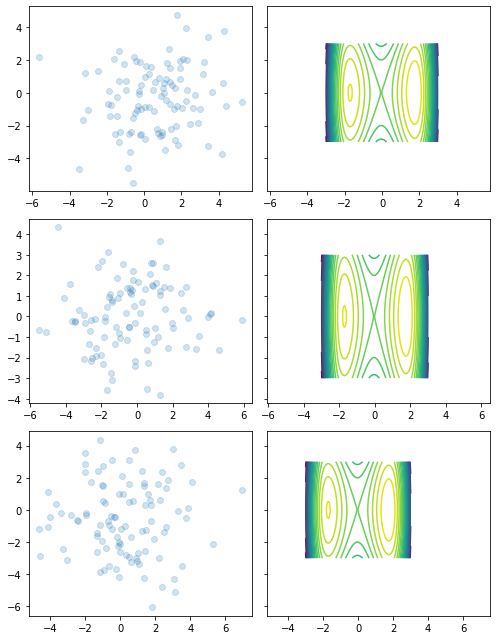

In [16]:
plot_samples_vs_contours_many_well(tester, n_samples=100)